<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score
from statsmodels.tsa.stattools import adfuller
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.tsa.ar_model import AR
from sklearn.model_selection import GridSearchCV

In [2]:
# Открываем файл с данными, переводим сразу даты в тип данных datetime64
# и устанавливаем индек таблицы по дате и времени
taxi = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0])

In [3]:
# Первые 5 строк
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
# Информация
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
# Статистические данные
taxi.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [6]:
# Хронология даты и времени
print(taxi.index.is_monotonic)

True


In [7]:
# Проведем ресемплирование по 1 часу
taxi = taxi.resample('1H').sum()

Что имеем на входе: 2 признака(или 1 признак?) и 26 496 наблюдений; пропусков нет, проведено ресемплирование до 1 часа.

## Анализ

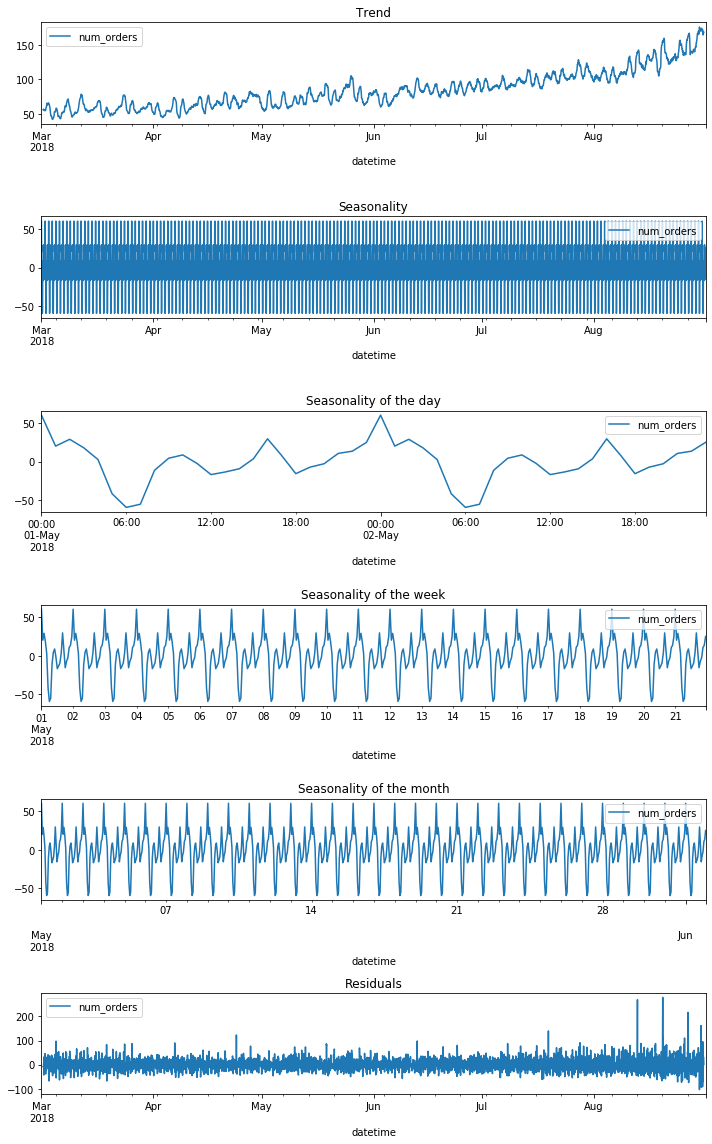

In [8]:
# Разложение временного ряда на: тренд, сезонность и шум
# Построение графиков
decomposed = seasonal_decompose(taxi)

plt.figure(figsize=(10, 16))
# Тренд
plt.subplot(611)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
# Сезонность
plt.subplot(612)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
# Внутрисуточная сезонность
plt.subplot(613)
decomposed.seasonal['2018-05-01':'2018-05-02'].plot(ax=plt.gca())
plt.title('Seasonality of the day')
# Недельная сезонность
plt.subplot(614)
decomposed.seasonal['2018-05-01':'2018-05-21'].plot(ax=plt.gca())
plt.title('Seasonality of the week')
# Месячная сезонность 
plt.subplot(615)
decomposed.seasonal['2018-05-01':'2018-06-01'].plot(ax=plt.gca()) 
plt.title('Seasonality of the month')
# Остаток
plt.subplot(616)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

Из графика скользящей средней и из графика "тренд" мы видим явно выраженную восходящую линию. Но так как данные у нас за 6 месяцев, мы не можем с точностью утверждать, что это восходящий тренд, возможно, это годовая сезонность, допустим, люди пользуются такси чаще в теплое время года, чем в холодное. На графике явно присутствует внутрисуточная сезонность с пиком в 00.00 часов и спадом в 06.00 часов.

In [9]:
# Статистичсекие данные по количеству заказов
taxi['num_orders'].describe()

count    4416.000000
mean       84.422781
std        45.023853
min         0.000000
25%        54.000000
50%        78.000000
75%       107.000000
max       462.000000
Name: num_orders, dtype: float64

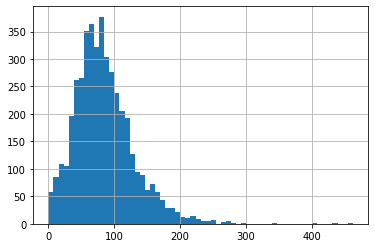

In [10]:
# Гистограмма заказов
taxi['num_orders'].hist(bins=60)

Распределение нормальное, в среднем 84 заказа в час, разброс 45. 

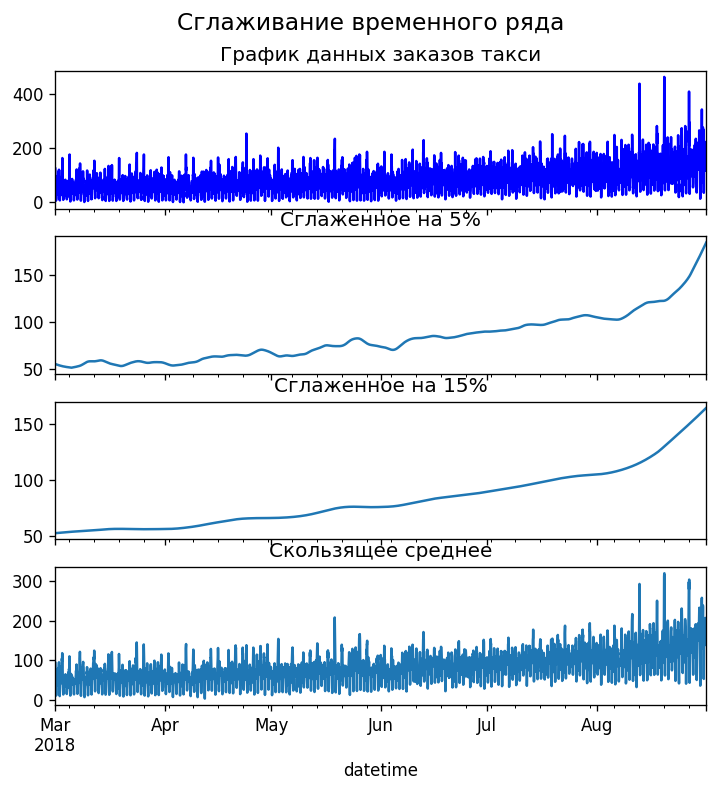

In [11]:
# Скользящее среднее значение ряда
taxi_ma = taxi['num_orders'].rolling(3, center=True, closed='both').mean()

# Сглаженное скользящее среднее на 5% и 15%
df_loess_5 = pd.DataFrame(lowess(taxi['num_orders'].values, np.arange(len(taxi['num_orders'].values)), frac=0.05)[:, 1], index=taxi.index, columns=['num_orders'])
df_loess_15 = pd.DataFrame(lowess(taxi['num_orders'].values, np.arange(len(taxi['num_orders'].values)), frac=0.15)[:, 1], index=taxi.index, columns=['num_orders'])

# Строим графики
fig, axes = plt.subplots(4,1, figsize=(7, 7), sharex=True, dpi=120)
taxi['num_orders'].plot(ax=axes[0], color='b', title='График данных заказов такси')
df_loess_5['num_orders'].plot(ax=axes[1], title='Сглаженное на 5%')
df_loess_15['num_orders'].plot(ax=axes[2], title='Сглаженное на 15%')
taxi_ma.plot(ax=axes[3], title='Скользящее среднее')
fig.suptitle('Сглаживание временного ряда', y=0.95, fontsize=14)
plt.show()

In [12]:
# Проверка на стационарность 
# Dickey-Fuller test 
result = adfuller(taxi['num_orders'].values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
if result[0]> result[4]['5%']: 
    print('Данные имеют единичные корни, ряд не стационарен')
else:
    print('Данные не имеют единичных корней, ряд стационарен')

ADF Statistic: -3.068924
p-value: 0.028940
Данные не имеют единичных корней, ряд стационарен


Из графиков мы видим явно выраженную восходящую линию. Но так как данные у нас за 6 месяцев, мы не можем с точностью утверждать, что это восходящий тренд, возможно, это годовая сезонность, допустим, люди пользуются такси чаще в теплое время года, чем в холодное. На графике явно присутствует внутрисуточная сезонность с пиком в 00.00 часов и спадом в 06.00 часов. Распределение нормальное, в среднем 84 заказа в час, разброс 45. Тест Дики-Фуллера показал, что нулевую гипотезу о том, что ряд нестационарен мы отклоняем, соответственно принимаем гипотезу о стационарности ряда.

## Обучение

In [13]:
# Создадим таблицу для показателей моделей
index_model_rmse = 0
model_rmse = pd.DataFrame(columns=['model','RMSE'])
model_rmse

,model,RMSE


In [14]:
# Копируем датасет для дальнейшего обучения
tax_copy = taxi.copy()

In [15]:
# Разделение выборки на обучающую и тестовую(0.9/0.1) и выделение целевого признака
train_c, test_c = train_test_split(tax_copy, shuffle=False, test_size=0.1)

In [16]:
# Предсказание предыдущим значением ряда
# Строка в таблице с показателями
pp = ['previous']
pred_previous = test_c.shift()
pred_previous.iloc[0] = train_c.iloc[-1]
rmse_p = mean_squared_error(test_c['num_orders'], pred_previous)** 0.5
# Добавим строку в таблицу с показателями
index_model_rmse +=1
model_rmse.loc[index_model_rmse] = ['previous', rmse_p]
model_rmse

,model,RMSE
1,previous,58.856486


In [17]:
# Предсказание константной моделью среднего значения
# Строка в таблице с показателями
pm = ['predict_mean']
pred_mean = np.ones(test_c.shape) * train_c['num_orders'].mean() 
rmse_k = mean_squared_error(test_c['num_orders'], pred_mean)** 0.5
rmse_k 
# Добавим строку в таблицу с показателями
index_model_rmse +=1
model_rmse.loc[index_model_rmse] = ['predict_mean', rmse_k]
model_rmse

,model,RMSE
1,previous,58.856486
2,predict_mean,84.744144


In [18]:
# Функция создания признаков
def make_features(data, max_lag, rolling_mean_size):
    # День недели
    data['dayofweek'] = data.index.dayofweek
    # Час
    data['hour'] = data.index.hour
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = taxi['num_orders'].shift(lag)
     # Предыдущий день
    taxi['previous_day'] = taxi['num_orders'].shift(24)
    # Скользящее среднее
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()    
   
make_features(taxi, 3, 150)

In [19]:
#Удалим пропущенные значения
taxi = taxi.dropna()

In [20]:
taxi

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,previous_day,rolling_mean
datetime,,,,,,,,
2018-03-07 06:00:00,19,2,6,10.0,73.0,66.0,7.0,53.753333
2018-03-07 07:00:00,17,2,7,19.0,10.0,73.0,10.0,53.053333
2018-03-07 08:00:00,38,2,8,17.0,19.0,10.0,25.0,52.600000
2018-03-07 09:00:00,50,2,9,38.0,17.0,19.0,52.0,52.380000
2018-03-07 10:00:00,34,2,10,50.0,38.0,17.0,51.0,52.273333
...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,4,19,207.0,217.0,197.0,72.0,154.173333
2018-08-31 20:00:00,154,4,20,136.0,207.0,217.0,142.0,154.660000
2018-08-31 21:00:00,159,4,21,154.0,136.0,207.0,198.0,154.820000


In [21]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4266 entries, 2018-03-07 06:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 8 columns):
num_orders      4266 non-null int64
dayofweek       4266 non-null int64
hour            4266 non-null int64
lag_1           4266 non-null float64
lag_2           4266 non-null float64
lag_3           4266 non-null float64
previous_day    4266 non-null float64
rolling_mean    4266 non-null float64
dtypes: float64(5), int64(3)
memory usage: 300.0 KB


In [22]:
# Разделение выборки на обучающую и тестовую(0.9/0.1) и выделение целевого признака
train, test = train_test_split(taxi, shuffle=False, test_size=0.1)
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [23]:
# Проверим
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-07 06:00:00 2018-08-14 04:00:00
2018-08-14 05:00:00 2018-08-31 23:00:00


Тестовая выборка начинается в 14.00 13 августа, а обучающая заканчивается в 13.00 13 августа. Данные разделили корректно.

In [24]:
# Дерево решений, автоматический подбор гиперпараметров
model_DTR = DecisionTreeRegressor(random_state=20202021)
parametr_DTR = {'max_depth': range (1, 19)}
tscv = TimeSeriesSplit(n_splits=5)
gs_DTR = GridSearchCV(model_DTR, parametr_DTR, cv = tscv, scoring = 'neg_mean_squared_error')
gs_DTR.fit(features_train, target_train)
print('максимальная глубина дерева', gs_DTR.best_params_)

максимальная глубина дерева {'max_depth': 5}


In [25]:
# Строка в таблице с показателями
dtr = ['decision_tree_regressor']
# Обучим и предскажем
model_DTR = DecisionTreeRegressor(random_state=20202021, max_depth = 5)
model_DTR.fit(features_train, target_train)
predictions_DTR = model_DTR.predict(features_test)
rmse_DTR = mean_squared_error(target_test, predictions_DTR)**(0.5)
# Добавим строку в таблицу с показателями
index_model_rmse +=1
model_rmse.loc[index_model_rmse] = ['decision_tree_regressor', rmse_DTR]
model_rmse

,model,RMSE
1,previous,58.856486
2,predict_mean,84.744144
3,decision_tree_regressor,52.346912


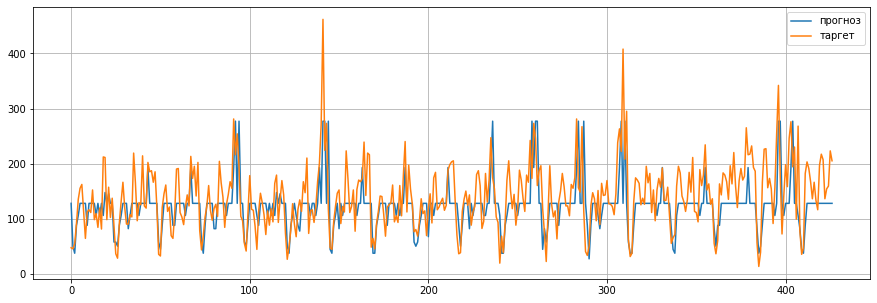

In [26]:
# График целевой признак-прогноз 
plt.figure(figsize=(15, 5))
plt.plot(predictions_DTR, label="прогноз")
plt.plot(list(target_test), label="таргет")
plt.grid(True)
plt.legend()

In [ ]:
# Случайный лес, автоматический подбор гиперпараметоров 
model_RFR = RandomForestRegressor(random_state=20202021)
parametrs_RFR = {'n_estimators': range (10, 31, 10),
             'max_depth': range (1, 11, 1)}
tscv = TimeSeriesSplit(n_splits=5)
gs_RFR = GridSearchCV(model_RFR, parametrs_RFR, scoring = 'neg_mean_squared_error', cv=tscv)
gs_RFR.fit(features_train, target_train)
print('лучшие параметры', gs_RFR.best_params_)

In [ ]:
# Строка в таблице с показателями
rfr = ['random_forest_regressor']
# Обучим и предскажем
model_RFR = RandomForestRegressor(max_depth = 10, n_estimators = 30, random_state=20202021)
model_RFR.fit(features_train, target_train)
predictions_RFR = model_RFR.predict(features_test)
rmse_RFR = mean_squared_error(target_test, predictions_RFR)**(0.5)
# Добавим строку в таблицу с показателями
index_model_rmse +=1
model_rmse.loc[index_model_rmse] = ['random_forest_regressor', rmse_RFR]
model_rmse

In [ ]:
# График целевой признак-прогноз 
plt.figure(figsize=(15, 5))
plt.plot(predictions_RFR, label="прогноз")
plt.plot(list(target_test), label="таргет")
plt.grid(True)
plt.legend()

In [ ]:
# Линейная регрессия, автоматический подбор гиперпараметоров 
model_LR = LinearRegression()
parametrs_LR = {'fit_intercept':[True,False], 
                   'normalize':[True,False]}
tscv = TimeSeriesSplit(n_splits=5)
gs_LR = GridSearchCV(model_LR, param_grid = parametrs_LR, scoring = 'neg_mean_squared_error', cv=tscv)
gs_LR.fit(features_train, target_train)
print('лучшие параметры', gs_LR.best_params_)

In [ ]:
# Строка в таблице с показателями
lr = ['linear_regression']
# Обучим и предскажем
model_LR = LinearRegression(fit_intercept = False, normalize = True)
model_LR.fit(features_train, target_train)
predictions_LR = gs_LR.predict(features_test)
rmse_LR = mean_squared_error(target_test, predictions_LR)**(0.5)
# Добавим строку в таблицу с показателями
index_model_rmse +=1
model_rmse.loc[index_model_rmse] = ['linear_regression', rmse_LR]
model_rmse

In [ ]:
# График целевой признак-прогноз 
plt.figure(figsize=(15, 5))
plt.plot(predictions_LR, label="прогноз")
plt.plot(list(target_test), label="таргет")
plt.grid(True)
plt.legend()

In [ ]:
# модель LightGBM с подбором гиперпараметров
model_lgbm = LGBMRegressor()
parametrs_lgbm = {'num_leaves': [10, 21],
                  'learning_rate': [0.01, 0.6],
                  'max_depth': [-1, 6]}
tscv = TimeSeriesSplit(n_splits=5)
gs_lgbm = GridSearchCV(model_lgbm, parametrs_lgbm, scoring = 'neg_mean_squared_error', cv=tscv)
gs_lgbm.fit(features_train, target_train)
print('лучшие параметры', gs_lgbm.best_params_)

In [ ]:
# Строка в таблице с показателями
lgbm = ['LGBMRegressor']
# Обучим и предскажем
model_lgbm = LGBMRegressor(num_leaves = 10, learning_rate = 0.6, max_depth = -1)
model_lgbm.fit(features_train, target_train)
predictions_lgbm = gs_lgbm.predict(features_test)
rmse_lgbm = mean_squared_error(target_test, predictions_lgbm)**(0.5)
# Добавим строку в таблицу с показателями
index_model_rmse +=1
model_rmse.loc[index_model_rmse] = ['LGBMRegressor', rmse_lgbm]
model_rmse

In [ ]:
# График целевой признак-прогноз 
plt.figure(figsize=(15, 5))
plt.plot(predictions_lgbm, label="прогноз")
plt.plot(list(target_test), label="таргет")
plt.grid(True)
plt.legend()

In [ ]:
# модель Catboost с подбором гиперпараметров
model_cbr = CatBoostRegressor(loss_function='RMSE')
parametrs_cb = {'learning_rate': [0.03, 0.1],
                 'depth': [4, 6, 10],
                 'l2_leaf_reg': [1, 31]}
tscv = TimeSeriesSplit(n_splits=5)
gs_cb = GridSearchCV(model_lgbm, parametrs_cb, scoring = 'neg_mean_squared_error', cv=tscv)
gs_cb.fit(features_train, target_train)
print('лучшие параметры', gs_cb.best_params_)

In [ ]:
# Строка в таблице с показателями
cb = ['catboost']
# Обучим и предскажем
model_cb = CatBoostRegressor(l2_leaf_reg = 1, learning_rate = 0.1, max_depth = 4)
model_cb.fit(features_train, target_train)
predictions_cb = gs_cb.predict(features_test)
rmse_cb = mean_squared_error(target_test, predictions_cb)**(0.5)
# Добавим строку в таблицу с показателями
index_model_rmse +=1
model_rmse.loc[index_model_rmse] = ['catboost', rmse_cb]
model_rmse

In [ ]:
# График целевой признак-прогноз 
plt.figure(figsize=(15, 5))
plt.plot(predictions_cb, label="прогноз")
plt.plot(list(target_test), label="таргет")
plt.grid(True)
plt.legend()

Были обучены 7 моделей
 - константная модель сренего значения;
 - модель предсказания предыдущим значением;
 - дерево решений;
 - случайный лес;
 - линейная регрессия;
 - LGBMRegressor;
 - catboost.

## Тестирование

In [ ]:
# Данные с метрикой rmse различных моделей
model_rmse

Лучшее значение rmse 43.5 показала модель CatBoostRegressor().

- Что имеем на входе: 2 признака и 26 496 наблюдений; пропусков нет, проведено ресемплирование до 1 часа.
- Из графиков мы видим явно выраженную восходящую линию. Но так как данные у нас за 6 месяцев, мы не можем с точностью утверждать, что это восходящий тренд, возможно, это годовая сезонность, допустим, люди пользуются такси чаще в теплое время года, чем в холодное. На графике явно присутствует внутрисуточная сезонность с пиком в 00.00 часов и спадом в 06.00 часов. Распределение нормальное, в среднем 84 заказа в час, разброс 45. Тест Дики-Фуллера показал, что нулевую гипотезу о том, что ряд нестационарен мы отклоняем, соответственно принимаем гипотезу о стационарности ряда.
- Были обучены 7 моделей
 - константная модель сренего значения;
 - модель предсказания предыдущим значением;
 - дерево решений;
 - случайный лес;
 - линейная регрессия;
 - LGBMRegressor;
 - catboost
- Лучшее значение rmse 44.8 показала модель CatBoostRegressor().

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48